はじめに
---
- 特徴量の表現にはいくつかの種類がある
- `連続値特徴量(continuous feature)`
    - データが連続した数値でならんでいる
    - 例: ピクセルの明るさ、花の大きさの測定値なの
- `カテゴリ特徴量`
    - `離散値特徴量`とも呼ばれる
    - 一般に数値ではない
    - 例: 製品のブランドや色、販売されている部門(書籍、衣料、金物）など
        - 基本的に連続的に変化しない値
- 特定のアプリケーションに対して、最良のデータ表現を模索することを「特徴量エンジニアリング」とよぶ

### カテゴリ変数

#### ワンホットエンコーディング(ダミー変数)
- カテゴリ変数を表現する方法として圧倒的によく使われる手法が「ワンホットエンコーディング(one-hot-encoding)」である
    - ダミー変数と呼ばれることもある
- ダミー変数とはカテゴリ変数を一つ以上の0と1の値をもつ新しい特徴量で置き換えるもの
- 一つの特徴量に対しては対応する値だったときに1になりそれ以外は0になる

##### pandasを使ったワンホットエンコーディング
- pandas#Series#value_contentで各行に含まれているユニークな値とその頻度を表示できる
- pandas#get_dummies関数を使うと簡単にデータをワンホットエンコーディングすることができる
- get_dummies関数は、訓練データとテストデータの両方に適用する必要がある

#### 数値でエンコードされているカテゴリ
- データセットが数値で表現されているからといって、連続値変数とは限らない
    - 1はxxx,2はyyyyなどのエンコードされていることはよくある
- pandasのget_dummies関数はすべての数値を連続値として扱いダミー変数を作らない
- これを回避するためには、連続値と離散値を指定することができるscikit-learnの`OneHotEncoder`を使うか、DataFrameの列を数値から文字列に変換してしまえばよい

In [1]:
from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
!pip install mglearn
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler
%matplotlib inline

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#  整数特徴量とカテゴリ文字列特徴量からなるDataFrameを作る
demo_df = pd.DataFrame({'Integer Feature': [0, 1, 2, 1], 'Categorical Feature': ['socke', 'fox', 'socks', 'box']})
display(demo_df)

,Categorical Feature,Integer Feature
0,socke,0
1,fox,1
2,socks,2
3,box,1


In [3]:
pd.get_dummies(demo_df)

,Integer Feature,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socke,Categorical Feature_socks
0,0,0,0,1,0
1,1,0,1,0,0
2,2,0,0,0,1
3,1,1,0,0,0


- 一度文字列に変換して#get_dummiesを掛けることで整数特徴量を変えずに変換できる

ビニング、離散化、線形モデル、決定木
---


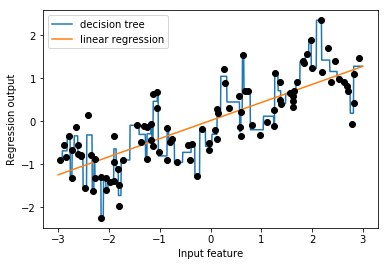

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_split=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

- 線形モデルは線形の関係しかモデリングできないため、一つしか特徴量がない場合には一本の線になる
- 決定木ははるかに複雑なモデルを構築することができる
- 線形モデルを連続データに対してより強力にする方法の一つとして特徴量の「ビニング(binning)」または「離散化(discretization)」がある

### ビニングを加えたwaveデータセットの線形回帰
- ①. まずは、特徴量の入力レンジを固定数の`ビン`例えば10個のビンに分割することを考える

In [5]:
bins = np.linspace(-3, 3, 11)
print(f"bins: {bins}")

bins: [-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]


- 最初のビンには-3~-2.4までのすべての数が入り、次のビンには-2.4~1.8までの数がはいる

- ② 次に個々のデータポイントがどのビンに入るかを記録する
    - これは「np.digitize」関数で簡単にできる
    

In [6]:
which_bin = np.digitize(X, bins=bins)
print("\nData points: \n", X[:5])
print("\nBin membership for data points: \n", which_bin[:5])


Data points: 
 [[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]

Bin membership for data points: 
 [[ 4]
 [10]
 [ 8]
 [ 6]
 [ 2]]


- ここでは、waveデータセットの単一の連続値入力特徴量のどのビンにデータポイントが入っているかを表現したカテゴリ特徴量の置き換えを行っている
- このデータにモデルを適用するには、この離散値特徴量をワンホットエンコーディングに変換する必要がある
    - これにはpreprocessionモジュールのOneHotEncoderを用いる
- ③ ワンホットエンコーディングへの変換

In [7]:
from sklearn.preprocessing import OneHotEncoder 
# OneHotEncoderで変換する
encoder = OneHotEncoder(sparse=False)
# encoder.fitでwhich_binに現れる整数値のバリエーションを確認
encoder.fit(which_bin)
# transformでワンホットエンコーディングを行う
X_binned = encoder.transform(which_bin)
print(X_binned[:5])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


- 10ビンを指定したので、変換されたデータ・セットX_binnedには10この特徴量ができている

In [8]:
print(f"X_binned.shape: {X_binned.shape}")

X_binned.shape: (100, 10)


- ④ 線形回帰モデルと決定木モデルをこのワンホットエンコーディングデータに対して作り直す

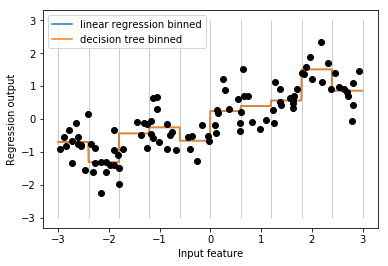

In [9]:
line_binned = encoder.transform(np.digitize(line, bins=bins))

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label="linear regression binned")

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label="decision tree binned")

plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(bins, -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

- 線形回帰と決定木が完全に同じ予測を行うことがわかる
- ビニング前後でモデルが学習したことを比較すると線形モデルに関してはより柔軟になっているのに対して、決定木モデルに関しては柔軟性が低下している
- 一般に、特徴量をビニングすることには決定木にとってはメリットはない
    - もともと決定木はデータを任意の場所で分割して学習できるため
- 線形モデルに置いてはこの変換による表現力の増大の効果は大きい
- あるデータセットに対してどうしても線形モデルを使いたい場合、いくつかの特徴量が出力と非線形な関係を持つようなら、ビニングを使うとモデルの表現力を増強することができる

交互作用特徴量(interaction feature)と多項式特徴量(polynomial feature)
---


In [10]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(100, 11)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# X **  10 までの多項式を加える
# デフォルトのinclude_bias=Trueだと常に1となる特徴量を加える
poly = PolynomialFeatures(h)

### 多項式(polynomial)
- ビニングは連続値特徴量を拡張する方法の１つだった
- もう一つの方法としてもとの特徴量の多項式を使う方法がある
    - ある特徴量ｘに対してx ** 2, x**3...を考える

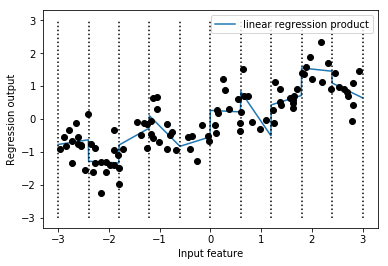

In [16]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')

それぞれのビンごとの傾きを表現するために、データポイントがどのビンに入っているかを示す特徴量とX軸のどこにあるかを示す特徴量の交互作用もしくは積を、特徴量として加える

In [15]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(100, 20)


- 上記はビニングされた特徴量と大域的な単一の傾きに対する線形回帰
- モデルは個々のビンに対してオフセットと傾きを学習する
- 傾きは下向きですべてのビンで共有されている
- 傾きがすべてのビンで共有されているのであまりやくには立たない

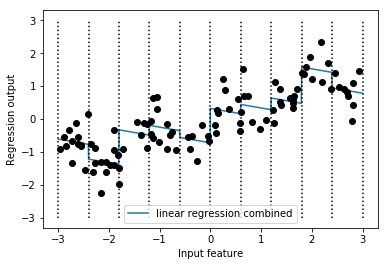

In [12]:
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')

In [18]:
from sklearn.preprocessing import PolynomialFeatures

# x ** 10までの多項式を加える。
# デフォルトの"include_bias=True"だと、常に1となる特徴量を加える
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

In [20]:
print(f"X_poly.shape: {X_poly.shape}")

X_poly.shape: (100, 10)


In [22]:
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_poly:\n{}".format(X_poly[:5]))

Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Entries of X_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]


In [24]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


- 個々の特徴量の意味は`get_feature_name`で知ることができる
- X_polyの各要素は最初の要素の冪乗となっている

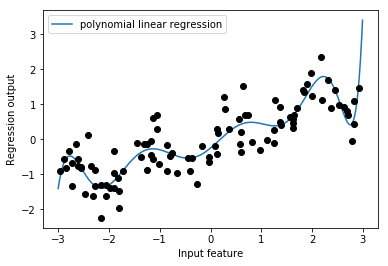

In [26]:
reg = LinearRegression().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

- 多項式特徴量は1次元のデータに対して非常にスムーズに適合する
- しかし、高次の多項式は、境界近辺やデータが少ない領域で極端な振る舞いを示す傾向にある


### 比較としてカーネル法を用いたSVMモデルを変換していないオリジナルデータに適用してみる

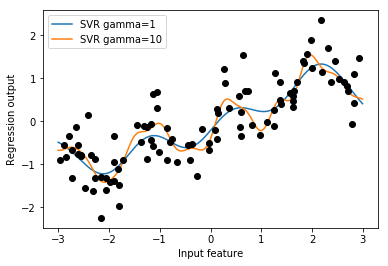

In [29]:
from sklearn.svm import SVR

for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))
    
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

- このように複雑なモデルを用いると特徴量に対して明示的な変換を行わなくても多項式回帰と同じように複雑な予測をすることができる

### 交互作用特徴量と多項式特徴量をboston_housingデータセットに適用する

In [31]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

# データのスケール変換(0~1になるように変換する)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# 2次までの多項式特徴量と交互作用を抽出
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


- もとのデータは13しか特徴量がなかったが、105の交互作用特徴量にまで拡張した
    - これらの新しい特徴量は、もとの特徴量から2つの特徴量のすべての組み合わせともとの特徴量の2乗である

In [35]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


- 入力特徴量と出力特徴量の正確な関係は`get_feature_names`メソッドでわかる

#### Ridgeを使って交互作用特徴量を入れた場合と入れない場合を比較する

In [37]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(ridge.score(X_test_scaled, y_test)))
ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(ridge.score(X_test_poly, y_test)))

Score without interactions: 0.621
Score with interactions: 0.753


- 交互作用特徴量と多項式特徴量を適用した場合の方がRidgeの性能は上がる

#### ランダムフォレストを使った比較

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(rf.score(X_test_scaled, y_test)))
rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.802
Score with interactions: 0.762


- ランダムフォレストのような複雑なモデルを使った場合、追加の特徴量がなくても性能はRidgeを上回る
- 逆に交互作用特徴量と多項式特徴量を追加すると性能がわずかに下がる

単変量非線形変換
---

- 線形モデルやニューラルネットワークモデルは個々の特徴量のスケールや分散と密接に結びついており、特徴量とターゲットに非線形関数があるとモデリングが難しくなる
    - 特に回帰で顕著
- logやexpなどの関数はデータの相対的なスケールを修正してくれるので線形モデルやニューラルネットワークモデルでモデリングしやすくなる
- ほとんどのモデルは個々の特徴量がおおよそガウス分布(正規分布)に従っているときに最もうまく機能する
    - ヒストグラムが見慣れた「ベル・カーブ」になる場合
- 特に有効なケースは整数のカウントデータを扱う場合

In [41]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)
X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

In [42]:
print(f"Number of feature appearances: \n{np.bincount(X[:, 0])}")

Number of feature appearances: 
[28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


- 値2が68回出てきて最も多く大きな値に対しては量が減っている

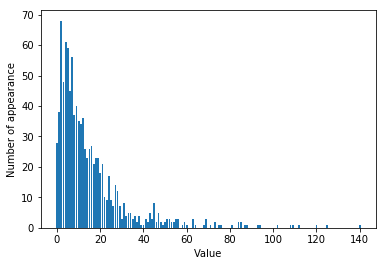

In [44]:
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins)
plt.ylabel("Number of appearance")
plt.xlabel("Value")

- この種の分布(小さい値がおおく稀にとても大きい値がでる)は実データにはよくある
    - ポワソン分布

In [45]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print(f"Test score: {score:.3f}")

Test score: 0.622


- RidgeではXとyの関係をうまく捉えられず精度がでない

### 対数変換を行う
- データに0があるため直接0を使うことはできない。したがってlog(X+1)を計算する

In [47]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

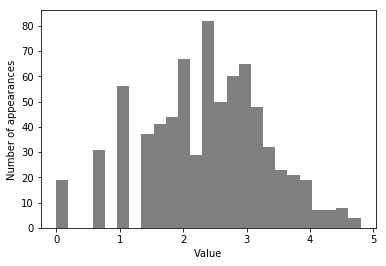

In [49]:
plt.hist(X_train_log[:, 0], bins=25, color='gray')
plt.ylabel("Number of appearances")
plt.xlabel("Value")

In [52]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.875


- 新しいデータに対してRidgeモデルを使うと性能ははるかに良くなる

自動特徴量選択
---


- 特徴量が多すぎるとモデルは複雑になり、過剰適合の可能性が高くなる
- 新しい特徴量を加える場合、または高次元データセット一般の場合、最も有用な特徴量だけを残して残りを捨てて特徴量の数をへらす方法を考える
- 良い特徴量を判定するための基本的な戦略が3つある
    - ① 単変量統計(univariate statistics)
    - ② モデルベース選択(model-based selection)
    - ③ 反復選択(iterative selection)
- これらの方法はすべて教師あり手法であるため、モデルを適合するためのターゲットが必要
- したがってデータを訓練セットとテストセットに分割し、特徴量選択は訓練セットだけをもしいて行うようにしなければならない


### 単変量統計
- 個々の特徴量とターゲットとの間に統計的に顕著な関係があるかどうかを計算する
- 計算結果として最も高い確信度で関連している特徴量が選択される
- クラス分類の場合は「分散分析(analysis of variance: ANOVA)」が知られている
- この方法の特性は`単変量`であること(個々の特徴量を個別に考慮する)
- したがって、他の特徴量と組み合わさって意味を持つような特徴量は捨てられてしまう

#### scikit-learnで使う場合
- テストを選択する
    - クラス分類には`f_classif`を回帰には`f_refression`を用いる
- 更にテストで求められるp値をもとに特徴量を捨てる方法も指定する
    - p値が大きすぎる特徴量を捨てる際の「スレッショルド」を指定する
        - SelectKBest: 選択する特徴量の数を指定する
        - SelectPercentile: 残す特徴量の割合を選択する

### cancerデータセットに適用

In [54]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# シードを指定して乱数を決定
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# ノイズ特徴量をデータに加える
# 最初の30特徴量はデータセットから来たもの。続く50特徴量はノイズ
X_w_noise = np.hstack([cancer.data, noise])
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)
# f_classif(デフォルト)とSelectPercentileを使って50%の特徴量を選択 
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# 訓練セットを変換
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


- 特徴量が80から40に減っている

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


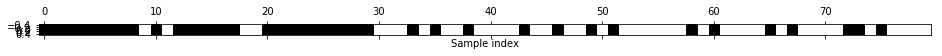

In [55]:
mask = select.get_support()
print(mask)
# マスクを可視化する -- 黒が真、白が偽
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

- どの特徴量が使われたかは「get_support」メソッドで調べることができる
- このメソッドは選択された特徴量を示す真偽値のマスクを返す

- もとの特徴量のほとんどが選択されており、ほとんどのノイズ特徴量は取り除かれている
    - すべてのもとの特徴量が選択されているわけではない

### ロジスティック回帰を使って選択された特徴量だけのときの性能を比較する

In [56]:
from sklearn.linear_model import LogisticRegression
# テストデータの変換
X_test_selected = select.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


- もとの特徴量のいくつかが失われているにもかかわらず、性能は向上している

### モデルベース特徴量選択
- 教師あり学習モデルを用いて個々の特徴量の重要性を判断し、重要なものだけを残す手法
- 特徴量選択に用いる学習モデルは最終的に使う教師あり学習モデルと同じではなくてよい
- 特徴量選択に用いるモデルは選択時に特徴量に順番をつけるために、個々の特徴量の重要性の指標を出力するものでなくてはならない
    - 決定木や決定木ベースのモデルには、特徴量の重要性そのものをエンコーディングした「feature_importances_」属性がある
    - 線形モデルは係数がある
        - L1ペナルティを用いた線形モデルは疎な係数を学習して特徴量のごく一部しか利用しないようになる
        
#### scikit-learnを使う場合
- SelectFromModel変換器を用いる

In [59]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
# ランダムフォレストを使った変換器を作成
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")

In [60]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


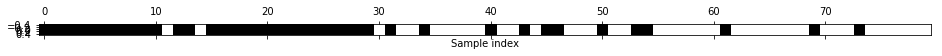

In [62]:
mask = select.get_support()
# マスクを可視化する -- 黒が真、白が偽
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

In [63]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


- 良い特徴量を選択することで性能も向上している

### 反復特徴量選択
- 異なる特徴量を用いた一連のモデルを作る
- これには２つの基本的な方法がある
- 一つは、全く特徴量をつかわないところから、ある基準がみたされるところまで1つずつ特徴量を加えていく方法
- もう一つはすべての特徴量を使う状態から1つずつ特徴量を取り除いていく方法
    - 多数のモデルをつくるため、加えていく方法よりも計算量的にはるかに高価な手法となる
    
#### 再帰的特徴量削減(recursive feature elemination: RFE)
- 特徴量を一つずつ減らしていく方法
- すべての特徴量から開始してモデルを作り、そのモデルで最も重要度が低い特徴量を削除する
- そしてまたモデルをつくり、最も重要度が低い特徴量を削除する
- 上記過程を事前に定めた数の特徴量になるまで繰り返す

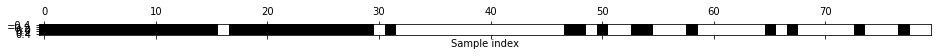

In [64]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)
select.fit(X_train, y_train)
# 選択された特徴量を可視化する
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

- モデルベースと比べてはるかに時間がかかる
- 一つずつモデルを削除するためランダムフォレストを40回学習しているため

In [66]:
X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)
score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


- モデルベースと精度は変わらない

In [67]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


- RFE内部で用いられたモデルを用いて予測を行うこともできる

- RFE内部で用いられたランダムフォレストの性能と選択された特徴量で訓練したロジスティック回帰モデルの性能は同じである
- つまり、適切な特徴量を選んだことで線形モデルの性能がランダムフォレストと同じになったとも言える